![](https://blockchainstock.azureedge.net/features/C47CB7081D81D4B6A5F3C2D5F97D14376DF75D5E3DDC5733953EABB79263589D.jpg "Creadit : https://blockchain.news/analysis/Why-bitcoin-price-correlation-stock-market-is-high-now")

# Introduction

This project will demonstrate Bitcoin (BTC-USD) stock closing price prediction using stacking bidirection LSTM (bi-LSTM)

Data is collected using `yfinance` API  

# Libraries & Configurations

In [1]:
%%capture
!pip install yfinance --upgrade --no-cache-dir

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, CuDNNLSTM, Bidirectional
from keras.layers import Activation, Dropout

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

plt.rcParams['figure.figsize'] = 12, 8

# Load Dataset

[yfinance API](https://github.com/ranaroussi/yfinance)

In [3]:
btc_ticker = yf.Ticker('BTC-USD')

df_btc_data = btc_ticker.history(period="max")

# to download for a specific period of time
# yf.download("BTC-USD", start="2014-01-01", end="2019-04-30")

# EDA

In [4]:
df_btc_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2021-11-09,67549.734375,68530.335938,66382.062500,66971.828125,42357991721,0,0
2021-11-10,66953.335938,68789.625000,63208.113281,64995.230469,48730828378,0,0
2021-11-11,64978.890625,65579.015625,64180.488281,64949.960938,35880633236,0,0


## Missing Values

In [5]:
pd.date_range(df_btc_data.index.min(), df_btc_data.index.max()).difference(df_btc_data.index)

DatetimeIndex(['2020-04-17', '2020-10-09', '2020-10-12', '2020-10-13'], dtype='datetime64[ns]', freq=None)

Since the ratio of missing dates is very low (~0.1%), no action is taken to fill missing values

## Target Column : `Close`

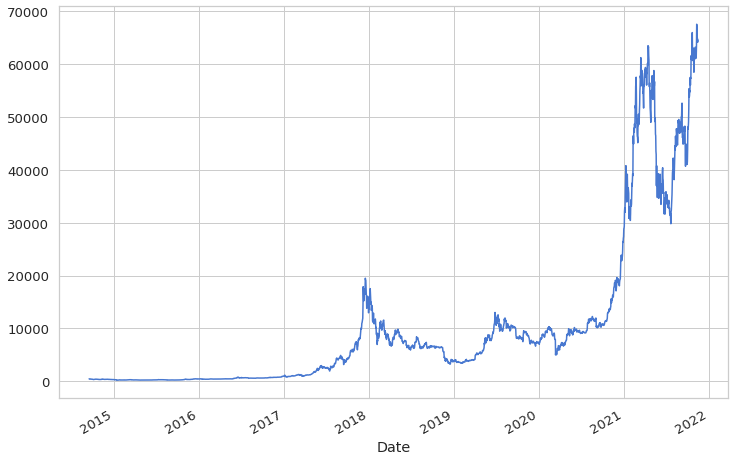

In [6]:
df_btc_data.Close.plot();

### Zooming IN (2018-02 to 2021-11)

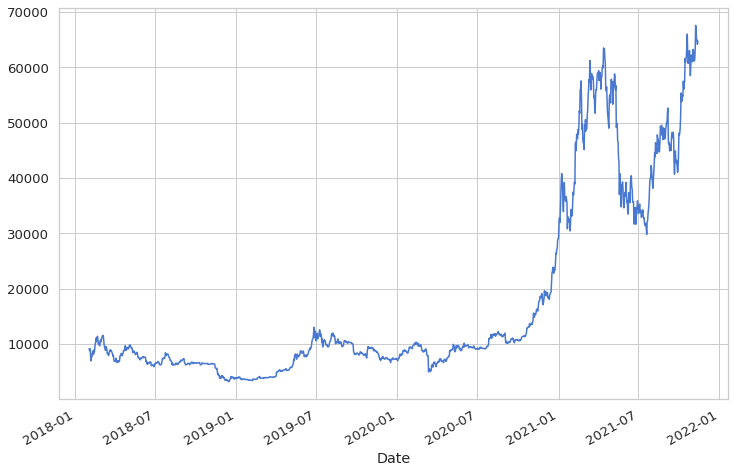

In [18]:
df_btc_data.loc['2018-01':'2021-11',"Close"].plot();

# Data Preparation
### Univariate Time Series Dataset With One Feature - Stock closing price

In [20]:
df_btc_close = df_btc_data[['Close']]
df_btc_close

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-11-09,66971.828125
2021-11-10,64995.230469
2021-11-11,64949.960938


## Scaling

In [21]:
scaler = MinMaxScaler()
close_price = df_btc_close.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [22]:
scaled_close.shape

(2611, 1)

In [23]:
scaled_close

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.96116758],
       [0.94938491],
       [0.95787257]])

**Check Missing value**

In [12]:
np.isnan(scaled_close).sum()

0

In [24]:
scaled_close.reshape(-1, 1).shape

(2611, 1)

## Prepare Sequence

Target Shape of The Data : `[batch_size, sequence_length, n_features]`

In [59]:
sequence_length = 100 # history of 99 input time steps

def to_sequences(data, seq_len):
  d = []
  for index in range(len(data) - seq_len):
    d.append(data[index: index + seq_len])

  return np.array(d)

def preprocess_data(data_raw, seq_len, train_split):
  data = to_sequences(data_raw, seq_len)
  num_train = int(train_split * data.shape[0])

  X_train = data[:num_train, :-1, :]
  y_train = data[:num_train, -1, :]
  
  # input->X1: [1 2 3...99]-> y1: 100
  # input->X2: [2 3 4...100]-> y2: 101
  # input->X3: [3 4 5...101]-> y3: 102

  X_test = data[num_train:, :-1, :]
  y_test = data[num_train:, -1, :]

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess_data(scaled_close, sequence_length, 0.9)

In [60]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2259, 99, 1), (2259, 1), (252, 99, 1), (252, 1))

# Modeling

## Stacking LSTM

In [16]:
# https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
# https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

model = Sequential()

# CuDNNLSTM is roughly 15x faster than LSTM

model.add(Bidirectional(
CuDNNLSTM(X_train.shape[1], return_sequences=True), 
input_shape=(X_train.shape[1], X_train.shape[-1])
))

# set return_sequences=True
# so that the second LSTM layer has a three-dimensional sequence input

model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM((X_train.shape[1] * 2), 
                                            return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(X_train.shape[1])))

model.add(Dense(units=1))
model.add(Activation('linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 99, 198)          80784     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 198)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 99, 396)          630432    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 198)              393624    
 nal)                                                            
                                                        

In [ ]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [17]:
BATCH_SIZE = 64

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, 
                    shuffle=False,  validation_split=0.1 )

Epoch 1/50
32/32 [==============================] - 16s 211ms/step - loss: 0.0027 - val_loss: 0.0525
Epoch 2/50
32/32 [==============================] - 5s 154ms/step - loss: 0.0033 - val_loss: 0.0516
Epoch 3/50
32/32 [==============================] - 5s 153ms/step - loss: 0.0020 - val_loss: 0.0338
Epoch 4/50
32/32 [==============================] - 5s 154ms/step - loss: 0.0020 - val_loss: 0.0250
Epoch 5/50
32/32 [==============================] - 5s 153ms/step - loss: 0.0015 - val_loss: 0.0131
Epoch 6/50
32/32 [==============================] - 5s 153ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 7/50
32/32 [==============================] - 5s 153ms/step - loss: 7.1743e-04 - val_loss: 0.0128
Epoch 8/50
32/32 [==============================] - 5s 153ms/step - loss: 6.5780e-04 - val_loss: 0.0103
Epoch 9/50
32/32 [==============================] - 5s 154ms/step - loss: 0.0011 - val_loss: 0.0381
Epoch 10/50
32/32 [==============================] - 5s 153ms/step - loss: 9.3656e-04 - val

# Evaluation

In [18]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 1s 66ms/step - loss: 0.0027


0.0027122455649077892

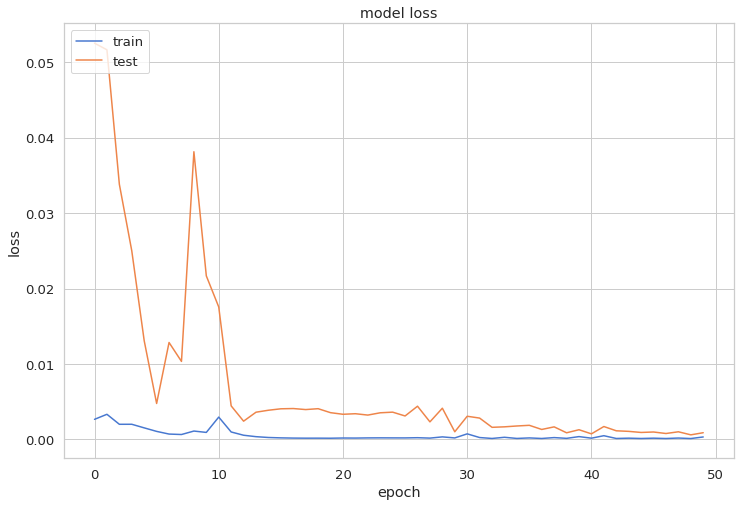

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

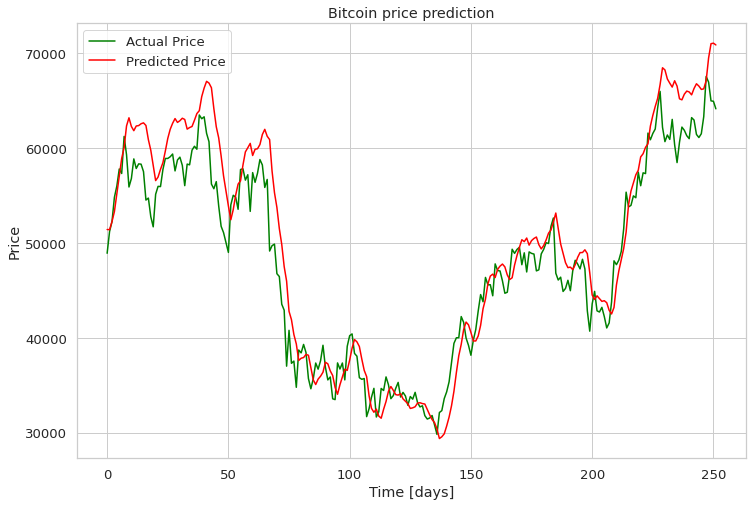

In [20]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();